# M1 GPU (tensorflow-metal installed)

## Summary
- **Key Question:** Can you detect if someone has COVID-19 based on their breathing patterns?.  In order to answer this question, I needed to build models which can classify the six (6) breathing patterns of different samples:  

  - normal breathing / Eupnea [1]
  - abnormal breathing such as:
    - Bradypnea [2]
    - Tachypnea [3]
    - Biots [4]
    - Cheyne-Stokes [5]
    - Central-Apnea [6] 

- The rapid breathing pattern (Tachypnea) has been often reported as a feature of COVID-19.

- **Method:**  Deep Learning techniques were trained on 120K training set that simulated respiratory patterns, and the test set (human test subjects recorded, Kinect V2 depth cameras) has 605 observations.  Note, the study participants were trained to breath in the major six patterns and compared against gold-standard instruments.  They are not COVID-19 patients, although one of the breathing patterns (Tachypnea) is a significant identifying symptom of the virus.

- **Techniques Used in the Original Study:** The original study focused on comparing four (4) deep learning neural networks for multiclass classification of the six repiratory patterns above.  All neural networks used were Recurrent Neural Networks (RNNs), specifically:  Gated Recurrent Unit (GRU), Long Short-Term Memory (LSTM), Bidirectional with Attention Layer LSTM (BI-AT-LSTM), and Bidirectional with Attention Layer GRU (BI-AT-GRU).  

- **My Focus**: Attemping to reproduce results for the first three (GRU, LSTM, BI-AT-LSTM), largely utilizing Amazon Web Services (AWS) Sagemaker for high performance CPU and GPU (Tesla V100) infrastructure.  Ultimately, I utilized the same neural network architecture, but had to adjust batch sizes.

- **Conclusion**: I could achieve results with similar metrics to the pre-print roughly (i.e. my results giving accuracy 77% - 83% instead of the 88% - 94%).

- **Original Pre-Print:**   
Wang, Yunlu; Hu, Menghan; Li, Qingli; Zhang, Xiao-Ping; Zhai, Guangtao; Yao, Nan.  Abnormal respiratory patterns classifier may contribute to large-scale screening of people infected with COVID-19 in an accurate and unobtrusive manner.  [Download Original Paper](https://arxiv.org/abs/2002.05534v1)

## Import Libraries
- **Metrics:** SkLearn
- **Model Loading:** Keras Model Loading
- **Plotting:** MatPlotLib and SciKitPLot

In [1]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix

from keras.models import load_model

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import scikitplot as skplt

## Import Data
- Import Procedure
    - Import Test dataset of 605 observations, with the first column as the respiratory pattern class (1-6), and the next 600 columns as respiratory pattern predictors.  Each predictor is a measure of respiratory pattern waveform amplitude every centi-second, thus alltogether describing a waveform over a total duration of 60 seconds and 10Hz.  Prior to import by the original study authors, various data transformation steps of normalization and other signal filters are applied, as described in the papers referenced below.
- High-level notes on datasets used:
    - Training Set was generated by the original publication's MATLAB simulator code.  Please see "Project 2" for details.  The models loaded were trained on this training set.
    - Test Set is the original publication's test set.  Please see details below.
- Dataset Details:
    - **Publication:**   
Wang, Yunlu; Hu, Menghan; Li, Qingli; Zhang, Xiao-Ping; Zhai, Guangtao; Yao, Nan.  Abnormal respiratory patterns classifier may contribute to large-scale screening of people infected with COVID-19 in an accurate and unobtrusive manner.  [Download Original Paper](https://arxiv.org/abs/2002.05534v1)
    - **Test Dataset:** 
Hu, Menghan (2020): Test dataset for [Download Original Paper](https://arxiv.org/abs/2002.05534v1) figshare. Dataset.  [Dowload Test Data](https://doi.org/10.6084/m9.figshare.12009600.v1)
    - **Train Dataset**:
Hu, Menghan (2019): Respiratory Pattern Simulation_ Model (RSM). figshare. Dataset.
[Download Training Simulator](https://doi.org/10.6084/m9.figshare.9978833.v1)
    - Note, "main.m" of RSM code was modified from "scale = 10" to "scale = 20000" to generate the original 120,000 results.

In [2]:
testSource = pd.read_csv("./Breathing_TEST.csv", header = None)
testDF = testSource
x_test = testDF.iloc[:, 1:601].to_numpy()
y_test = testDF.iloc[:, 0].to_numpy()
testDF.info()
testDF.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 605 entries, 0 to 604
Columns: 601 entries, 0 to 600
dtypes: float64(600), int64(1)
memory usage: 2.8 MB


,0,1,2,3,4,5,6,7,8,9,...,591,592,593,594,595,596,597,598,599,600
count,605.000000,605.000000,605.000000,605.000000,605.000000,605.000000,605.000000,605.000000,605.000000,605.000000,...,605.000000,605.000000,605.000000,605.000000,605.000000,605.000000,605.000000,605.000000,605.000000,605.000000
mean,3.409917,0.486449,0.498953,0.502535,0.502367,0.500512,0.494951,0.486926,0.480696,0.475430,...,0.625216,0.625978,0.625562,0.628096,0.628292,0.628888,0.628409,0.628059,0.625525,0.623175
std,1.719743,0.323598,0.291186,0.277246,0.276744,0.279495,0.282198,0.287191,0.287338,0.285658,...,0.258694,0.259598,0.262011,0.264840,0.265360,0.264834,0.264775,0.264248,0.264480,0.268629
min,1.000000,0.000000,0.000000,0.002593,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.003179,0.002935,0.000000,0.012048,0.010195,0.012720,0.021676,0.016040,0.002457,0.003491
25%,2.000000,0.210650,0.258800,0.266970,0.256240,0.251420,0.255330,0.244670,0.224780,0.217810,...,0.438310,0.431750,0.427450,0.421860,0.423160,0.430500,0.430200,0.438020,0.426620,0.423760
50%,3.000000,0.493430,0.496110,0.507520,0.515030,0.514190,0.498510,0.483250,0.474220,0.480680,...,0.655180,0.654210,0.656180,0.657920,0.650980,0.656050,0.655460,0.666210,0.652400,0.655390
75%,5.000000,0.761350,0.740740,0.730350,0.735880,0.733690,0.742520,0.735030,0.721880,0.706260,...,0.853690,0.851040,0.859920,0.867560,0.872620,0.872880,0.875110,0.867640,0.861440,0.865150
max,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.998980,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.990760,1.000000


## Helper Functions
 - Functions to help load models that we have alread trained, utilizing the industry standard HDF5 format, see [https://en.wikipedia.org/wiki/Hierarchical_Data_Format#HDF5](https://en.wikipedia.org/wiki/Hierarchical_Data_Format#HDF5)
- Functions include:  modelSummary, confusionMatrix (absolute and normalized), plotRocAuc, and plotPrecisionRecall
- Please see SciKitPLot, a helpful library to automatically plot ROC/AUC for multi-class problems, [https://github.com/reiinakano/scikit-plot](https://github.com/reiinakano/scikit-plot).  Note, this is likely based on ideas in SciKit Learn's example on adapting ROC/AUC for multi-class classification problems, [https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html)

In [3]:
def modelSummary(modelPath):
    model = load_model(modelPath)
    model.summary()

def confusionMatrix(modelPath, normBool):
    model = load_model(modelPath)
    y_prob = model.predict(x_test) 
    predictions = y_prob.argmax(axis=-1)
    predictions = predictions.reshape(len(testDF),)
    skplt.metrics.plot_confusion_matrix(y_test, predictions, normalize=normBool)
    plt.show()
    
def classificationReport(modelPath):
    model = load_model(modelPath)
    y_prob = model.predict(x_test, batch_size=32) 
    predictions = y_prob.argmax(axis=-1)
    predictions = predictions.reshape(len(testDF),)
    print(classification_report(y_test, predictions, labels=[1,2,3,4,5,6], zero_division=0))   

def plotRocAuc(modelPath):
    model = load_model(modelPath)
    y_prob = model.predict(x_test) 
    skplt.metrics.plot_roc(y_test, y_prob[:,1:7])
    plt.show()
    
def plotPrecisionRecall(modelPath):
    model = load_model(modelPath)
    y_prob = model.predict(x_test) 
    skplt.metrics.plot_precision_recall(y_test, y_prob[:,1:7])
    plt.show()

# Gated Recurrent Unit (GRU)

- Model Summary
- Classification Report
- Confusion Matrix (Normalized)
- Confusion Matrix (Absolute)
- Receiver Operating Characteristic (RoC) Curves and Area Under Curve (AUC)
- Precision-Recall Curvies

- Additional Info on Model Types
  - [https://en.wikipedia.org/wiki/Gated_recurrent_unit](https://en.wikipedia.org/wiki/Gated_recurrent_unit)
  - [https://en.wikipedia.org/wiki/Recurrent_neural_network](https://en.wikipedia.org/wiki/Recurrent_neural_network)
  


## GRU - Model Summary
- Key Hyperparameters
  - Batch Size: 128

In [4]:
modelSummary("./gru/best_model.h5")

Metal device set to: Apple M1 Max
Model: "respiratory"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 600, 1)]          0         
_________________________________________________________________
gru (GRU)                    (None, 128)               50304     
_________________________________________________________________
dense (Dense)                (None, 7)                 903       
Total params: 51,207
Trainable params: 51,207
Non-trainable params: 0
_________________________________________________________________


2021-11-22 14:52:41.889120: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-11-22 14:52:41.889325: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## GRU - Classification Report
- See links:
  - [https://muthu.co/understanding-the-classification-report-in-sklearn/](https://muthu.co/understanding-the-classification-report-in-sklearn/)
  - [https://en.wikipedia.org/wiki/Precision_and_recall](https://en.wikipedia.org/wiki/Precision_and_recall)  

In [5]:
classificationReport("./gru/best_model.h5")

2021-11-22 14:52:46.297308: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-22 14:52:46.297491: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-11-22 14:52:46.367248: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-22 14:52:46.385276: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

           1       0.88      0.91      0.89       108
           2       0.87      0.95      0.91       108
           3       0.93      0.93      0.93       108
           4       1.00      0.67      0.80        87
           5       0.56      0.87      0.68        97
           6       0.50      0.30      0.37        97

    accuracy                           0.78       605
   macro avg       0.79      0.77      0.76       605
weighted avg       0.79      0.78      0.77       605



## GRU - Confusion Matrix (Absolute)
- See [https://en.wikipedia.org/wiki/Confusion_matrix](https://en.wikipedia.org/wiki/Confusion_matrix)

2021-11-22 14:52:53.627523: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-22 14:52:53.643226: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


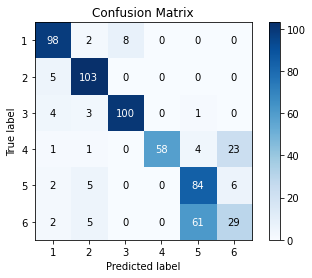

In [6]:
confusionMatrix("./gru/best_model.h5", False)

## GRU - Confusion Matrix (Normalized)
- See [https://en.wikipedia.org/wiki/Confusion_matrix](https://en.wikipedia.org/wiki/Confusion_matrix) 

2021-11-22 14:53:02.496235: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-22 14:53:02.511921: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


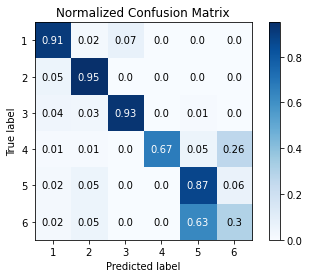

In [7]:
confusionMatrix("./gru/best_model.h5", True)

## GRU - Receiver Operating Characteristic (RoC) Curves and Area Under Curve (AUC)
- See links: 
  - [https://en.wikipedia.org/wiki/Receiver_operating_characteristic](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)
  - [https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve)
  - [https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/) 

2021-11-22 14:53:10.438519: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-22 14:53:10.454505: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


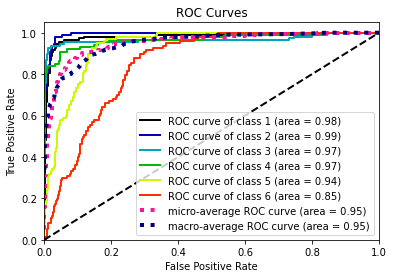

In [8]:
plotRocAuc("./gru/best_model.h5")

## GRU - Precision-Recall Curve
- See links:
  - [https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/) 
  - [https://en.wikipedia.org/wiki/Precision_and_recall](https://en.wikipedia.org/wiki/Precision_and_recall)

2021-11-22 14:53:16.196189: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-22 14:53:16.211871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


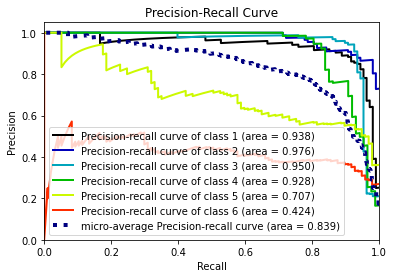

In [9]:
plotPrecisionRecall("./gru/best_model.h5")

# Long Short-Term Memory (LSTM)

- Model Summary
- Classification Report
- Confusion Matrix (Normalized)
- Confusion Matrix (Absolute)
- Receiver Operating Characteristic (RoC) Curves and Area Under Curve (AUC)
- Precision-Recall Curvies

- Additional Info on Model Types
    - [https://en.wikipedia.org/wiki/Long_short-term_memory](https://en.wikipedia.org/wiki/Long_short-term_memory)
  
    - [https://en.wikipedia.org/wiki/Recurrent_neural_network](https://en.wikipedia.org/wiki/Recurrent_neural_network)
  


## LSTM - Model Summary
- Key Hyperparameters
  - Batch Size: 32

In [10]:
modelSummary("./lstm/best_model.h5")

Model: "respiratory"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 600, 1)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dense (Dense)                (None, 7)                 903       
Total params: 67,463
Trainable params: 67,463
Non-trainable params: 0
_________________________________________________________________


## LSTM - Classification Report
- See links:
  - [https://muthu.co/understanding-the-classification-report-in-sklearn/](https://muthu.co/understanding-the-classification-report-in-sklearn/)
  - [https://en.wikipedia.org/wiki/Precision_and_recall](https://en.wikipedia.org/wiki/Precision_and_recall)  

In [11]:
classificationReport("./lstm/best_model.h5")

2021-11-22 14:53:28.819051: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-22 14:53:28.836087: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

           1       0.21      0.54      0.30       108
           2       0.00      0.00      0.00       108
           3       0.00      0.00      0.00       108
           4       0.13      0.17      0.15        87
           5       0.24      0.52      0.33        97
           6       0.50      0.01      0.02        97

   micro avg       0.21      0.20      0.21       605
   macro avg       0.18      0.21      0.13       605
weighted avg       0.18      0.20      0.13       605



## LSTM - Confusion Matrix (Absolute)
- See [https://en.wikipedia.org/wiki/Confusion_matrix](https://en.wikipedia.org/wiki/Confusion_matrix)

2021-11-22 14:53:33.702499: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-22 14:53:33.719646: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


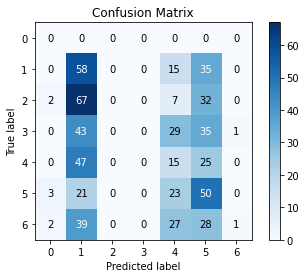

In [12]:
confusionMatrix("./lstm/best_model.h5", False)

## LSTM - Confusion Matrix (Normalized)
- See [https://en.wikipedia.org/wiki/Confusion_matrix](https://en.wikipedia.org/wiki/Confusion_matrix) 

2021-11-22 14:53:48.167008: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-22 14:53:48.184424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
/opt/homebrew/Caskroom/miniforge/base/envs/ds/lib/python3.9/site-packages/scikitplot/metrics.py:124: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


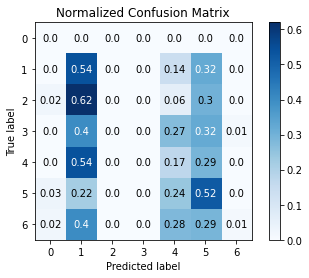

In [13]:
confusionMatrix("./lstm/best_model.h5", True)

## LSTM - Receiver Operating Characteristic (RoC) Curves and Area Under Curve (AUC)
- See links: 
  - [https://en.wikipedia.org/wiki/Receiver_operating_characteristic](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)
  - [https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve)
  - [https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/) 

2021-11-22 14:53:52.874484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-22 14:53:52.891681: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


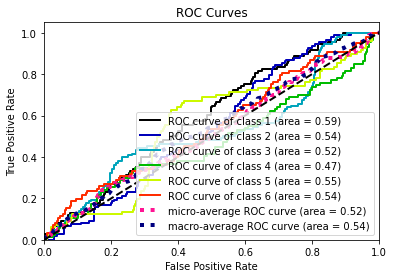

In [14]:
plotRocAuc("./lstm/best_model.h5")

## LSTM - Precision-Recall Curve
- See links:
  - [https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/) 
  - [https://en.wikipedia.org/wiki/Precision_and_recall](https://en.wikipedia.org/wiki/Precision_and_recall)

2021-11-22 14:53:57.718881: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-22 14:53:57.736328: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


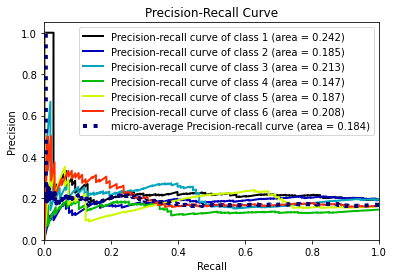

In [15]:
plotPrecisionRecall("./lstm/best_model.h5")